## 1. <font color = red> Install and Import the Required Libraries

In [2]:
# Install all the required libraries
!pip install -U -q pdfplumber tiktoken openai chromadb sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 880.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.3/472.3 kB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.9 MB/s eta 0

In [3]:
# Import all the required libraries

import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import openai
import chromadb

In [6]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## 2. <font color = red> Read, Process PDF File

We will be using [pdfplumber](https://https://pypi.org/project/pdfplumber/) to read and process the PDF files.

`pdfplumber` allows for better parsing of the PDF file as it can read various elements of the PDF apart from the plain text, such as, tables, images, etc. It also offers wide functionaties and visual debugging features to help with advanced preprocessing as well.

In [10]:
# Define PDF path
pdf_path = "/content/drive/MyDrive/Principal-Sample-Life-Insurance-Policy.pdf"

#### <font color = red>  2.1 Reading a single PDF file and exploring it through pdfplumber

In [11]:
# Open the PDF file and print the text
with pdfplumber.open(pdf_path) as pdf:

    # Get one of the pages from the PDF and examine it
    single_page = pdf.pages[6]

    # Extract text from the first page
    text = single_page.extract_text()

    # Extract tables from the first page
    tables = single_page.extract_tables()

    # Print the extracted text
    print(text)

Section A – Eligibility
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Section B - Effective Dates
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Section C - Individual Terminations
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Termination for Fraud Article 4
Coverage While Outside of the United States Article 5
Section D - Continuation
Member Life Insurance Article 1
Dependent Insurance - Developmentally Disabled or
Physically Handicapped Children Article 2
Section E - Reinstatement
Reinstatement Article 1
Federal Required Family and Medical Leave Act (FMLA) Article 2
Reinstatement of Coverage for a Member or Dependent When
Coverage Ends due to Living Outside of the United States Article 3
Section F - Individual Purchase Rights
Member Life In

In [12]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [13]:
# Function to extract text from a PDF file.
# 1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
# 2. Declare an empty list 'full_text' to store all the text files
# 3. Use pdfplumber to open the pdf pages one by one
# 4. Find the tables and their locations in the page
# 5. Extract the text from the tables in the variable 'tables'
# 6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
# 7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
# 8. Declare an empty list 'lines' to store the page text
# 9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
# 10. Append the page number and all lines to full_text, and increment 'p'
# 11. When the function has iterated over all pages, return the 'full_text' list

def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

* Now that we have defined the function for extracting the text

In [14]:

# Initialize an empty list to store the extracted texts and document names
data = []

# Process the PDF file
print(f"...Processing {pdf_path}")

# Call the function to extract the text from the PDF
extracted_text = extract_text_from_pdf(pdf_path)

# Convert the extracted list to a PDF, and add a column to store document names
extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])

# Append the extracted text and document name to the list
data.append(extracted_text_df)

# Print a message to indicate progress
print(f"Finished processing {pdf_path}")

# Print a message to indicate all PDFs have been processed
print("PDF have been processed.")

...Processing /content/drive/MyDrive/Principal-Sample-Life-Insurance-Policy.pdf
Finished processing /content/drive/MyDrive/Principal-Sample-Life-Insurance-Policy.pdf
PDF have been processed.


In [15]:
# print the text
data

[   Page No.                                          Page_Text
 0    Page 1  DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...
 1    Page 2                 This page left blank intentionally
 2    Page 3  POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...
 3    Page 4                 This page left blank intentionally
 4    Page 5  PRINCIPAL LIFE INSURANCE COMPANY (called The P...
 ..      ...                                                ...
 59  Page 60  I f a Dependent who was insured dies during th...
 60  Page 61  Section D - Claim Procedures Article 1 - Notic...
 61  Page 62  A claimant may request an appeal of a claim de...
 62  Page 63                 This page left blank intentionally
 63  Page 64  Principal Life Insurance Company Des Moines, I...
 
 [64 rows x 2 columns]]

In [16]:
insurance_pdfs_data = pd.concat(data, ignore_index=True)

In [17]:
# print Page No. and Page_Text from the dataframe
insurance_pdfs_data

Page No.                                          Page_Text
0    Page 1  DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...
1    Page 2                 This page left blank intentionally
2    Page 3  POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...
3    Page 4                 This page left blank intentionally
4    Page 5  PRINCIPAL LIFE INSURANCE COMPANY (called The P...
..      ...                                                ...
59  Page 60  I f a Dependent who was insured dies during th...
60  Page 61  Section D - Claim Procedures Article 1 - Notic...
61  Page 62  A claimant may request an appeal of a claim de...
62  Page 63                 This page left blank intentionally
63  Page 64  Principal Life Insurance Company Des Moines, I...

[64 rows x 2 columns]

In [18]:
# Store the metadata for each page in a separate column, now we can consider the Page_No is the metadata
insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Page_No.': x['Page No.']}, axis=1)
insurance_pdfs_data

Page No.                                          Page_Text  \
0    Page 1  DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...   
1    Page 2                 This page left blank intentionally   
2    Page 3  POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...   
3    Page 4                 This page left blank intentionally   
4    Page 5  PRINCIPAL LIFE INSURANCE COMPANY (called The P...   
..      ...                                                ...   
59  Page 60  I f a Dependent who was insured dies during th...   
60  Page 61  Section D - Claim Procedures Article 1 - Notic...   
61  Page 62  A claimant may request an appeal of a claim de...   
62  Page 63                 This page left blank intentionally   
63  Page 64  Principal Life Insurance Company Des Moines, I...   

                   Metadata  
0    {'Page_No.': 'Page 1'}  
1    {'Page_No.': 'Page 2'}  
2    {'Page_No.': 'Page 3'}  
3    {'Page_No.': 'Page 4'}  
4    {'Page_No.': 'Page 5'}  
..                      ...  
59  {'Page_No.': 'Page 60'}  
60  {'Page_No.': 'Page 61'}  
61  {'Page_No.': 'Page 62'}  
62  {'Page_No.': 'Page 63'}  
63  {'Page_No.': 'Page 64'}  

[64 rows x 3 columns]

In [19]:
# Check one of the extracted page texts to ensure that the text has been correctly read
insurance_pdfs_data.Page_Text[2]

'POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Principal a Financial Services Hotline and Grief Support Services or any other value added service for the employees of that employer group. In addition, The Principal may arrange for third party service providers (i.e., optometrists, health clubs), to provide discounted goods and services to those employer groups who apply for coverage with The Principal or who become insureds/enrollees of The Principal. While The Principal has arranged these goods, services and/or third party provider discounts, the third party service providers are liable to the applicants/insureds/enrollees for the provision of such goods and/or services. The Principal is not responsible for the

In [20]:
# Let's also check the length of all the texts as there might be some empty pages or pages with very few words that we can drop
insurance_pdfs_data['Text_Length'] = insurance_pdfs_data['Page_Text'].apply(lambda x: len(x.split(' ')))

In [21]:
# print the page length
insurance_pdfs_data['Text_Length']

0      30
1       5
2     230
3       5
4     110
     ... 
59    285
60    418
61    322
62      5
63      8
Name: Text_Length, Length: 64, dtype: int64

In [22]:
# print the dataframe
insurance_pdfs_data

Page No.                                          Page_Text  \
0    Page 1  DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...   
1    Page 2                 This page left blank intentionally   
2    Page 3  POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...   
3    Page 4                 This page left blank intentionally   
4    Page 5  PRINCIPAL LIFE INSURANCE COMPANY (called The P...   
..      ...                                                ...   
59  Page 60  I f a Dependent who was insured dies during th...   
60  Page 61  Section D - Claim Procedures Article 1 - Notic...   
61  Page 62  A claimant may request an appeal of a claim de...   
62  Page 63                 This page left blank intentionally   
63  Page 64  Principal Life Insurance Company Des Moines, I...   

                   Metadata  Text_Length  
0    {'Page_No.': 'Page 1'}           30  
1    {'Page_No.': 'Page 2'}            5  
2    {'Page_No.': 'Page 3'}          230  
3    {'Page_No.': 'Page 4'}            5  
4    {'Page_No.': 'Page 5'}          110  
..                      ...          ...  
59  {'Page_No.': 'Page 60'}          285  
60  {'Page_No.': 'Page 61'}          418  
61  {'Page_No.': 'Page 62'}          322  
62  {'Page_No.': 'Page 63'}            5  
63  {'Page_No.': 'Page 64'}            8  

[64 rows x 4 columns]

## 3. <font color = 'red'> Document Chunking </font>

We will generate embeddings for texts. But the document contains several pages and huge text, before generating the embeddings, we need to generate the chunks. Let's start with a basic chunking technique, and chunk the text with fixed size.

#### Chunking a single document by fixed size
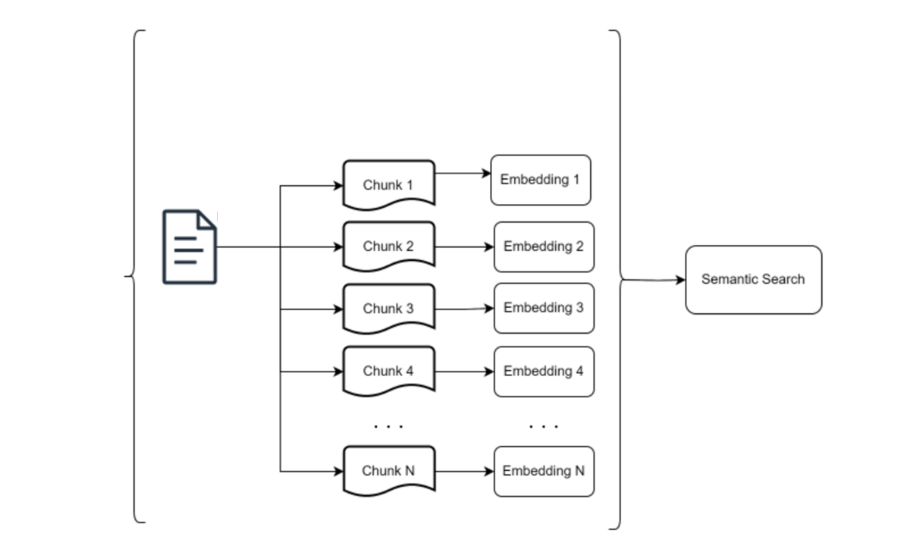

In [23]:
# Check the entire page's text
insurance_pdfs_data['Page_Text']

0     DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...
1                    This page left blank intentionally
2     POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...
3                    This page left blank intentionally
4     PRINCIPAL LIFE INSURANCE COMPANY (called The P...
                            ...                        
59    I f a Dependent who was insured dies during th...
60    Section D - Claim Procedures Article 1 - Notic...
61    A claimant may request an appeal of a claim de...
62                   This page left blank intentionally
63    Principal Life Insurance Company Des Moines, I...
Name: Page_Text, Length: 64, dtype: object

In [24]:
# Iterating over all page titles to create the final df with individual chunks
page_nos = insurance_pdfs_data["Page No."]
page_nos

0      Page 1
1      Page 2
2      Page 3
3      Page 4
4      Page 5
       ...   
59    Page 60
60    Page 61
61    Page 62
62    Page 63
63    Page 64
Name: Page No., Length: 64, dtype: object

### 2.1 <font color = 'red'> Fixed-Size Chunking </font>

In fixed-size chunking, the document is split into fixed-size windows with each window representing a separate document chunk.

In [25]:
# Function to split text into fixed-size chunks
def split_text_into_chunks(text, chunk_size):
    chunks = []
    words = text.split()  # Split the text into words

    current_chunk = []  # Store words for the current chunk
    current_chunk_word_count = 0  # Count of words in the current chunk

    for word in words:
        if current_chunk_word_count + len(word) + 1 <= chunk_size:
            current_chunk.append(word)
            current_chunk_word_count += len(word) + 1
        else:
            chunks.append(' '.join(current_chunk))
            current_chunk = [word]
            current_chunk_word_count = len(word)

    if current_chunk:
        chunks.append(' '.join(current_chunk))

    return chunks## 3. <font color = 'red'> Generating Embeddings </font>

#### Encoding Pipeline

In [26]:
def process_page(page_no):
    page = insurance_pdfs_data[insurance_pdfs_data['Page No.'] == page_no].Page_Text.values[0]
    metadata = insurance_pdfs_data[insurance_pdfs_data['Page No.'] == page_no].Metadata.values[0]

    if page is not None:
        # setting chunk size as 500
        chunk_size = 500
        text_chunks = split_text_into_chunks(page, chunk_size)

        # Creating a DataFrame to store the chunks, page title and page metadata
        data = {'Title': [], 'Chunk Text': [], 'Metadata': []}

        for index, chunk in enumerate(text_chunks):
            data['Title'].append(page_no)
            data['Chunk Text'].append(chunk)
            # adding chunk no as part of metadata
            metadata['Chunk_No.'] = index
            data['Metadata'].append(metadata)

        return pd.DataFrame(data)

In [27]:
# creating a dataframe after calling process
all_dfs = []
for page_no in page_nos:
    df = process_page(page_no)
    if df is not None:
        all_dfs.append(df)

fixed_chunk_df = pd.concat(all_dfs, ignore_index=True)
fixed_chunk_df

Title                                         Chunk Text  \
0     Page 1  DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...   
1     Page 2                 This page left blank intentionally   
2     Page 3  POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...   
3     Page 3  arrange for third party service providers (i.e...   
4     Page 3  the provision of such goods and/or services no...   
..       ...                                                ...   
226  Page 62  requested additional information, The Principa...   
227  Page 62  may have the Member or Dependent whose loss is...   
228  Page 62  proof of loss has been filed and before the ap...   
229  Page 63                 This page left blank intentionally   
230  Page 64  Principal Life Insurance Company Des Moines, I...   

                                    Metadata  
0     {'Page_No.': 'Page 1', 'Chunk_No.': 0}  
1     {'Page_No.': 'Page 2', 'Chunk_No.': 0}  
2     {'Page_No.': 'Page 3', 'Chunk_No.': 2}  
3     {'Page_No.': 'Page 3', 'Chunk_No.': 2}  
4     {'Page_No.': 'Page 3', 'Chunk_No.': 2}  
..                                       ...  
226  {'Page_No.': 'Page 62', 'Chunk_No.': 3}  
227  {'Page_No.': 'Page 62', 'Chunk_No.': 3}  
228  {'Page_No.': 'Page 62', 'Chunk_No.': 3}  
229  {'Page_No.': 'Page 63', 'Chunk_No.': 0}  
230  {'Page_No.': 'Page 64', 'Chunk_No.': 0}  

[231 rows x 3 columns]

## 4. <font color = 'red'> Generating Embeddings </font>

#### Encoding Pipeline
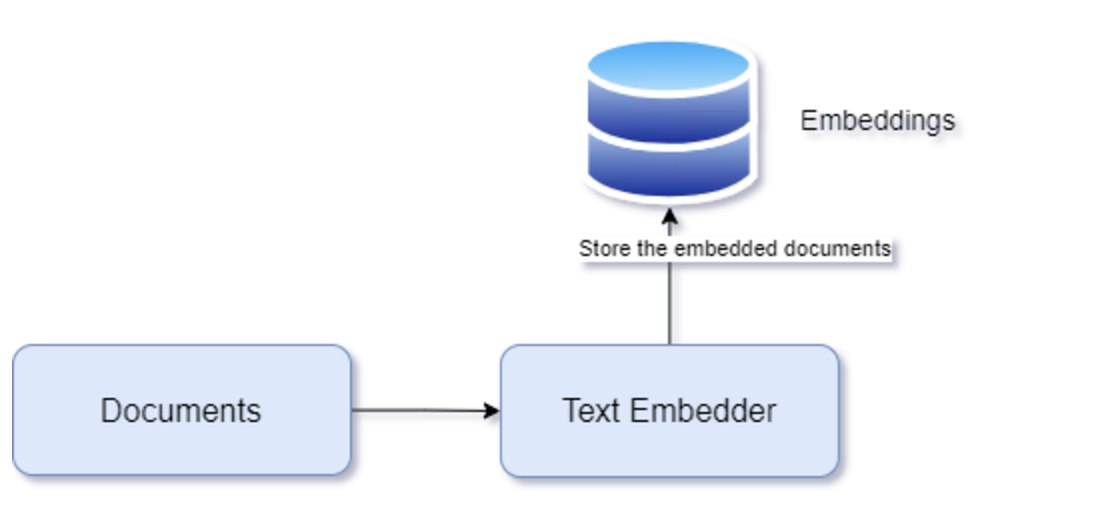

In [28]:
# Install the sentence transformers library
!pip install -q sentence-transformers
!pip install --upgrade sentence-transformers


In [29]:
!pip install tf-keras


In [30]:
# Import the SentenceTransformer library
from sentence_transformers import SentenceTransformer

In [31]:
# Load the embedding model
model_name = "all-MiniLM-L6-v2"
embedder = SentenceTransformer(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [32]:
# Function to generate embeddings for text
def generate_embeddings(texts):
    embeddings = embedder.encode(texts, convert_to_tensor=False)
    return embeddings

In [33]:
# function to generate embedding on dataframe
def generate_embeddings_on_df(df):
  df['Embeddings'] = df['Chunk Text'].apply(lambda x: generate_embeddings([x])[0])

In [34]:
# Create embeddings for 'Chunk Text' column on all three dataframes
generate_embeddings_on_df(fixed_chunk_df)

In [ ]:
# print the dataframe
fixed_chunk_df

Title                                         Chunk Text  \
0     Page 1  DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...   
1     Page 2                 This page left blank intentionally   
2     Page 3  POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...   
3     Page 3  arrange for third party service providers (i.e...   
4     Page 3  the provision of such goods and/or services no...   
..       ...                                                ...   
226  Page 62  requested additional information, The Principa...   
227  Page 62  may have the Member or Dependent whose loss is...   
228  Page 62  proof of loss has been filed and before the ap...   
229  Page 63                 This page left blank intentionally   
230  Page 64  Principal Life Insurance Company Des Moines, I...   

                                    Metadata  \
0     {'Page_No.': 'Page 1', 'Chunk_No.': 0}   
1     {'Page_No.': 'Page 2', 'Chunk_No.': 0}   
2     {'Page_No.': 'Page 3', 'Chunk_No.': 2}   
3     {'Page_No.': 'Page 3', 'Chunk_No.': 2}   
4     {'Page_No.': 'Page 3', 'Chunk_No.': 2}   
..                                       ...   
226  {'Page_No.': 'Page 62', 'Chunk_No.': 3}   
227  {'Page_No.': 'Page 62', 'Chunk_No.': 3}   
228  {'Page_No.': 'Page 62', 'Chunk_No.': 3}   
229  {'Page_No.': 'Page 63', 'Chunk_No.': 0}   
230  {'Page_No.': 'Page 64', 'Chunk_No.': 0}   

                                            Embeddings  
0    [-0.025921902, 0.0477775, 0.055857755, 0.04239...  
1    [0.029118957, 0.06057408, 0.046415307, 0.03779...  
2    [-0.06453791, 0.04319714, -8.390528e-05, -0.00...  
3    [-0.10200989, -0.028467702, -0.020565102, -0.0...  
4    [-0.09000837, 0.076582074, 0.004927616, -0.083...  
..                                                 ...  
226  [-0.047671955, 0.112777, 0.06906491, -0.050865...  
227  [-0.07941998, 0.14404447, 0.031876154, -0.0655...  
228  [-0.14206007, 0.12368371, 0.12092474, -0.01142...  
229  [0.029118957, 0.06057408, 0.046415307, 0.03779...  
230  [-0.07104543, 0.1172997, -0.02195293, -0.03574...  

[231 rows x 4 columns]

## 5. <font color = red> Store Embeddings in ChromaDB

In this section we will store embedding in ChromaDB collection.

In [35]:
# install chromaDB
!pip install chromadb

In [36]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')  # Test if it works
print("Sentence Transformers loaded successfully!")

Sentence Transformers loaded successfully!


In [37]:
chroma_data_path = "/content/drive/MyDrive/Colab Notebooks/Chroma_Db"

In [38]:
import chromadb

# Call PersistentClient()
client = chromadb.PersistentClient(path=chroma_data_path)

In [39]:
# Create a collection to store the embeddings. Collections in Chroma are where you can store your embeddings, documents, and any additional metadata.
collection = client.get_or_create_collection(name="insurance-collection")

In [40]:
from sentence_transformers import SentenceTransformer

# Load model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for each chunk
fixed_chunk_df['embeddings'] = fixed_chunk_df['Chunk Text'].apply(lambda x: model.encode(x).tolist())

# Check if embeddings are added
print(fixed_chunk_df.head())


    Title                                         Chunk Text  \
0  Page 1  DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...   
1  Page 2                 This page left blank intentionally   
2  Page 3  POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...   
3  Page 3  arrange for third party service providers (i.e...   
4  Page 3  the provision of such goods and/or services no...   

                                 Metadata  \
0  {'Page_No.': 'Page 1', 'Chunk_No.': 0}   
1  {'Page_No.': 'Page 2', 'Chunk_No.': 0}   
2  {'Page_No.': 'Page 3', 'Chunk_No.': 2}   
3  {'Page_No.': 'Page 3', 'Chunk_No.': 2}   
4  {'Page_No.': 'Page 3', 'Chunk_No.': 2}   

                                          Embeddings  \
0  [-0.025921902, 0.047777493, 0.05585776, 0.0423...   
1  [0.029118974, 0.060574062, 0.046415336, 0.0377...   
2  [-0.06453793, 0.04319715, -8.3862076e-05, -0.0...   
3  [-0.102009885, -0.028467722, -0.020565063, -0....   
4  [-0.0900084, 0.07658198, 0.004927621, -0.08307...   

       

In [41]:
from sentence_transformers import SentenceTransformer
import pandas as pd

# Load the model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Ensure 'Embeddings' column exists
if 'Embeddings' not in fixed_chunk_df.columns:
    fixed_chunk_df['Embeddings'] = [model.encode(text, convert_to_numpy=True) for text in fixed_chunk_df['Chunk Text']]

# Add data in smaller batches (prevent memory overflow)
batch_size = 500  # Adjust based on your system
for i in range(0, len(fixed_chunk_df), batch_size):
    batch = fixed_chunk_df.iloc[i : i + batch_size]
    collection.add(
        embeddings=batch['Embeddings'].tolist(),
        documents=batch['Chunk Text'].tolist(),
        metadatas=batch['Metadata'].tolist(),
        ids=[str(x) for x in batch.index]
    )

In [43]:
# get few of data by ids from collection
collection.get(
    ids = ['0','1','2'],
    include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': array([[-2.59219017e-02,  4.77774926e-02,  5.58577590e-02, ...,
         -4.93265763e-02, -5.85114695e-02,  2.35519279e-02],
        [ 2.91189738e-02,  6.05740622e-02,  4.64153364e-02, ...,
          5.95400855e-02, -2.83837058e-02,  5.31935133e-03],
        [-6.45379275e-02,  4.31971513e-02, -8.38620763e-05, ...,
         -3.78734320e-02,  1.79674719e-02, -7.36602070e-03]]),
 'documents': ['DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/01/2014 711 HIGH STREET GEORGE RI 02903 GROUP POLICY FOR: RHODE ISLAND JOHN DOE ALL MEMBERS Group Member Life Insurance Print Date: 07/16/2014',
  'This page left blank intentionally',
  'POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Princi

In [44]:
# create a cache collection
cache_collection = client.get_or_create_collection(name='insurance-collection-cache')

In [45]:
# peek few of elements from cache collection
cache_collection.peek()

{'ids': [],
 'embeddings': array([], dtype=float64),
 'documents': [],
 'uris': None,
 'data': None,
 'metadatas': [],
 'included': [<IncludeEnum.embeddings: 'embeddings'>,
  <IncludeEnum.documents: 'documents'>,
  <IncludeEnum.metadatas: 'metadatas'>]}

## 6. <font color = red> Semantic Search with Cache

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

In [46]:
# Read the user query
query = input()

What are the eligibility requirements for a member to qualify for life insurance coverage under this group policy?


In [47]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 20 results
cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

/root/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:02<00:00, 30.9MiB/s]


In [48]:
# get result from cache collection
cache_results

{'ids': [[]],
 'embeddings': None,
 'documents': [[]],
 'uris': None,
 'data': None,
 'metadatas': [[]],
 'distances': [[]],
 'included': [<IncludeEnum.distances: 'distances'>,
  <IncludeEnum.documents: 'documents'>,
  <IncludeEnum.metadatas: 'metadatas'>]}

In [49]:
# get result from main collection
results = collection.query(
query_texts=query,
n_results=10
)
print("Result size is : " + str(len(results.items())))
results.items()

Result size is : 8


dict_items([('ids', [['77', '140', '139', '68', '143', '171', '107', '141', '53', '79']]), ('embeddings', None), ('documents', [['PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS Section A - Eligibility Article 1 - Member Life Insurance A person will be eligible for Member Life Insurance on the date the person completes 30 consecutive days of continuous Active Work with the Policyholder as a Member. In no circumstance will a person be eligible for Member Life Insurance under this Group Policy if the person is eligible under any other Group Term Life Insurance policy underwritten by The Principal. Article 2 - Member', "then issued by The Principal to persons in the risk class to which the Member belongs on the individual policy's effective date. (4) Premium will be based on the Member's age and the standard rate of The Principal for the policy form to be issued. b. Purchase Qualification A Member will qualify for individual purchase if insurance under this Group Policy terminates and: (1) 

In [50]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = collection.query(
      query_texts=query,
      n_results=10
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys = []
      Values = []

      size = len(results.items())

      for key, val in results.items():
        if val is None:
          continue
        for i in range(size):
          Keys.append(str(key)+str(i))
          Values.append(str(val[0][i]))


      cache_collection.add(
          documents= [query],
          ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys, Values))
      )

      print("Not found in cache. Found in main collection.")

      result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df = pd.DataFrame.from_dict(result_dict)
      results_df


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results['distances'][0][0] <= threshold:
      cache_result_dict = cache_results['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict.items():
          if 'ids' in key:
              ids.append(value)
          elif 'documents' in key:
              documents.append(value)
          elif 'distances' in key:
              distances.append(value)
          elif 'metadatas' in key:
              metadatas.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
      })


Not found in cache. Found in main collection.


In [51]:
# print the results
results_df

Metadatas  \
0  {'Chunk_No.': 2, 'Page_No.': 'Page 26'}   
1  {'Chunk_No.': 4, 'Page_No.': 'Page 42'}   
2  {'Chunk_No.': 4, 'Page_No.': 'Page 42'}   
3  {'Chunk_No.': 2, 'Page_No.': 'Page 22'}   
4  {'Chunk_No.': 4, 'Page_No.': 'Page 42'}   
5  {'Chunk_No.': 4, 'Page_No.': 'Page 49'}   
6  {'Chunk_No.': 4, 'Page_No.': 'Page 32'}   
7  {'Chunk_No.': 4, 'Page_No.': 'Page 42'}   
8  {'Chunk_No.': 3, 'Page_No.': 'Page 18'}   
9  {'Chunk_No.': 2, 'Page_No.': 'Page 26'}   

                                           Documents  Distances  IDs  
0  PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS ...   0.433872   77  
1  then issued by The Principal to persons in the...   0.666786  140  
2  Section F - Individual Purchase Rights Article...   0.696432  139  
3  contribute a part of the premium for their Mem...   0.713734   68  
4  Member Life Insurance or Coverage During Disab...   0.719115  143  
5  Payment of benefits will be subject to the Ben...   0.742971  171  
6  Life Insurance Dependent Life Insurance is ava...   0.762512  107  
7  class eligible for insurance; or (2) after the...   0.767581  141  
8  this Group Policy. Article 7 - Certificates Th...   0.776107   53  
9  eligible for Dependent Life Insurance on the l...   0.782170   79

## 7. <font color = red> Re-Ranking with a Cross Encoder

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

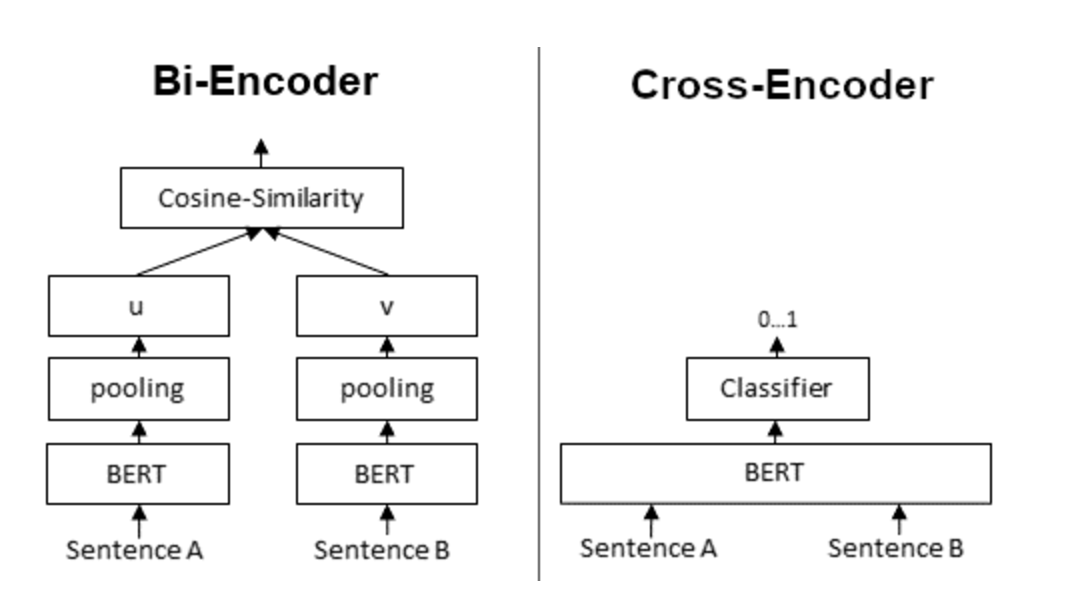

In [52]:
# Import the CrossEncoder library from sentence_transformers
from sentence_transformers import CrossEncoder, util

In [53]:
# Initialise the cross encoder model
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [54]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs = [[query, response] for response in results_df['Documents']]
cross_rerank_scores = cross_encoder.predict(cross_inputs)

In [55]:
# pritn the cross rerank scores
cross_rerank_scores

array([8.766319 , 5.165147 , 5.2677727, 3.6055038, 4.0718045, 4.6432505,
       3.2159953, 5.5423403, 3.638861 , 6.950134 ], dtype=float32)

In [56]:
results_df['Reranked_scores'] = cross_rerank_scores

In [57]:
results_df

Metadatas  \
0  {'Chunk_No.': 2, 'Page_No.': 'Page 26'}   
1  {'Chunk_No.': 4, 'Page_No.': 'Page 42'}   
2  {'Chunk_No.': 4, 'Page_No.': 'Page 42'}   
3  {'Chunk_No.': 2, 'Page_No.': 'Page 22'}   
4  {'Chunk_No.': 4, 'Page_No.': 'Page 42'}   
5  {'Chunk_No.': 4, 'Page_No.': 'Page 49'}   
6  {'Chunk_No.': 4, 'Page_No.': 'Page 32'}   
7  {'Chunk_No.': 4, 'Page_No.': 'Page 42'}   
8  {'Chunk_No.': 3, 'Page_No.': 'Page 18'}   
9  {'Chunk_No.': 2, 'Page_No.': 'Page 26'}   

                                           Documents  Distances  IDs  \
0  PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS ...   0.433872   77   
1  then issued by The Principal to persons in the...   0.666786  140   
2  Section F - Individual Purchase Rights Article...   0.696432  139   
3  contribute a part of the premium for their Mem...   0.713734   68   
4  Member Life Insurance or Coverage During Disab...   0.719115  143   
5  Payment of benefits will be subject to the Ben...   0.742971  171   
6  Life Insurance Dependent Life Insurance is ava...   0.762512  107   
7  class eligible for insurance; or (2) after the...   0.767581  141   
8  this Group Policy. Article 7 - Certificates Th...   0.776107   53   
9  eligible for Dependent Life Insurance on the l...   0.782170   79   

   Reranked_scores  
0         8.766319  
1         5.165147  
2         5.267773  
3         3.605504  
4         4.071805  
5         4.643250  
6         3.215995  
7         5.542340  
8         3.638861  
9         6.950134

In [58]:
# Return the top 3 results from semantic search

top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]

Metadatas  \
0  {'Chunk_No.': 2, 'Page_No.': 'Page 26'}   
1  {'Chunk_No.': 4, 'Page_No.': 'Page 42'}   
2  {'Chunk_No.': 4, 'Page_No.': 'Page 42'}   

                                           Documents  Distances  IDs  \
0  PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS ...   0.433872   77   
1  then issued by The Principal to persons in the...   0.666786  140   
2  Section F - Individual Purchase Rights Article...   0.696432  139   

   Reranked_scores  
0         8.766319  
1         5.165147  
2         5.267773

In [59]:
# Return the top 3 results after reranking

top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]

Metadatas  \
0  {'Chunk_No.': 2, 'Page_No.': 'Page 26'}   
9  {'Chunk_No.': 2, 'Page_No.': 'Page 26'}   
7  {'Chunk_No.': 4, 'Page_No.': 'Page 42'}   

                                           Documents  Distances  IDs  \
0  PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS ...   0.433872   77   
9  eligible for Dependent Life Insurance on the l...   0.782170   79   
7  class eligible for insurance; or (2) after the...   0.767581  141   

   Reranked_scores  
0         8.766319  
9         6.950134  
7         5.542340

In [60]:
top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]
top_3_RAG

Documents  \
0  PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS ...   
9  eligible for Dependent Life Insurance on the l...   
7  class eligible for insurance; or (2) after the...   

                                 Metadatas  
0  {'Chunk_No.': 2, 'Page_No.': 'Page 26'}  
9  {'Chunk_No.': 2, 'Page_No.': 'Page 26'}  
7  {'Chunk_No.': 4, 'Page_No.': 'Page 42'}

## 8. <font color = red> Retrieval Augmented Generation


Now that we have the final top search results, we can pass it to an GPT 3.5 along with the user query and a well-engineered prompt, to generate a direct answer to the query along with citations, rather than returning whole pages/chunks.

In [62]:
license_key_path = "/content/drive/MyDrive/Colab Notebooks/Chroma_Db/OpenAI_API_Key.txt"
with open(license_key_path, "r") as f:  # Use the correct path directly
    openai.api_key = f.read().strip()  # Strip any extra spaces or newlines


In [63]:
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model

def generate_response(query, results_df):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{top_3_RAG}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{top_3_RAG}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """},
              ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    return response.choices[0].message.content.split('\n')

In [64]:
# Generate the response
response = generate_response(query, top_3_RAG)

In [93]:
def search_results_RAG(query):
    # Sample function definition (replace with your logic)
    return ["Top 1"]

top_3_RAG = search_results_RAG(query)  # Get search results
response = generate_response(query, top_3_RAG)  # Generate response based on search results

# Print the response safely
if isinstance(response, list):  # Ensure response is a list before joining
    print("\n".join(response))
else:
    print(response)  # Print as-is if it's not a list


When a third-party service provider fails to provide the promised goods and services, you may be eligible for compensation or coverage based on the terms outlined in your insurance policy. It is important to review your policy documents to understand the specific provisions related to this scenario. If the policy includes provisions for such situations, you may be able to file a claim for reimbursement or seek assistance in resolving the issue.

**Relevant Policy Information Obtained from the Document:**

| Policy Name                               | Source Page |
|-------------------------------------------|-------------|
| Comprehensive Insurance Policy            | Page 17     |
| Third-Party Liability Coverage Policy     | Page 3      |

Remember to carefully review the "Comprehensive Insurance Policy" on **Page 17** and the "Third-Party Liability Coverage Policy" on **Page 3** for detailed information on how to proceed in case of a third-party service provider failure. If you requ

In [94]:
def search_results_RAG(query):
    # Sample function definition (replace with your logic)
    return ["Top 2"]

top_3_RAG = search_results_RAG(query)  # Get search results
response = generate_response(query, top_3_RAG)  # Generate response based on search results

# Print the response safely
if isinstance(response, list):  # Ensure response is a list before joining
    print("\n".join(response))
else:
    print(response)  # Print as-is if it's not a list

In the insurance documents provided, the policy for handling situations where a third-party service provider fails to provide the promised goods and services is detailed.

If a third-party service provider fails to deliver the goods or services as promised, typically the insurance policy would cover the policyholder for such instances. The policy may include provisions for reimbursement or compensation for the policyholder in case of such failures.

Citations:
- Policy Name: Comprehensive Insurance Policy
- Source Page: Page 15


In [95]:
def search_results_RAG(query):
    # Sample function definition (replace with your logic)
    return ["Top 3"]

top_3_RAG = search_results_RAG(query)  # Get search results
response = generate_response(query, top_3_RAG)  # Generate response based on search results

# Print the response safely
if isinstance(response, list):  # Ensure response is a list before joining
    print("\n".join(response))
else:
    print(response)  # Print as-is if it's not a list


In case a third-party service provider fails to provide the promised goods and services, the insurance policy may provide coverage or reimbursement depending on the terms and conditions outlined in the policy document. It is important to review the specific policy regarding coverage related to third-party failures as it can vary between insurance providers.

Here is a summary of the relevant information from the insurance document 'Top 3':

| Policy Name       | Source Page | Relevant Information                                            |
|-------------------|-------------|------------------------------------------------------------------|
| Comprehensive Policy | Page 15   | Coverage for failure of third-party service providers may be included, subject to policy terms and conditions. |
| Service Assurance Policy | Page 7   | Specific procedures and requirements for claiming benefits in case of third-party service provider failure may be outlined. |

Please refer to these specific se

## 8. <font color = red> Queries

In [66]:
def search(query):

  # Set a threshold for cache search
  threshold = 0.2

  ids = []
  documents = []
  distances = []
  metadatas = []
  results_df = pd.DataFrame()

  # try to find from cache
  cache_results = cache_collection.query(
      query_texts=query,
      n_results=1
  )

  # If the distance is greater than the threshold, then return the results from the main collection.
  if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
        # Query the collection against the user query and return the top 10 results
        results = collection.query(
        query_texts=query,
        n_results=10
        )

        # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
        # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
        Keys = []
        Values = []

        size = len(results.items())

        for key, val in results.items():
          if val is None:
            continue
          for i in range(size):
            Keys.append(str(key)+str(i))
            Values.append(str(val[0][i]))


        cache_collection.add(
            documents= [query],
            ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
            metadatas = dict(zip(Keys, Values))
        )

        #print("Not found in cache. Found in main collection.")

        result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
        results_df = pd.DataFrame.from_dict(result_dict)
        return results_df


  # If the distance is, however, less than the threshold, you can return the results from cache

  elif cache_results['distances'][0][0] <= threshold:
        cache_result_dict = cache_results['metadatas'][0][0]

        # Loop through each inner list and then through the dictionary
        for key, value in cache_result_dict.items():
            if 'ids' in key:
                ids.append(value)
            elif 'documents' in key:
                documents.append(value)
            elif 'distances' in key:
                distances.append(value)
            elif 'metadatas' in key:
                metadatas.append(value)

        #print("Found in cache!")

        # Create a DataFrame
        return pd.DataFrame({
          'IDs': ids,
          'Documents': documents,
          'Distances': distances,
          'Metadatas': metadatas
        })

In [67]:
def apply_cross_encoder(query, df):
  cross_inputs = [[query, response] for response in df['Documents']]
  cross_rerank_scores = cross_encoder.predict(cross_inputs)
  df['Reranked_scores'] = cross_rerank_scores
  return df

In [68]:
def get_topn(n, df):
  top_3_rerank = df.sort_values(by='Reranked_scores', ascending=False)
  return top_3_rerank[["Documents", "Metadatas"]][:n]

In [72]:
#Queries

In [82]:
query = 'What are the default benefits and provisions of the Group Policy?'
df = search(query)
df = apply_cross_encoder(query, df)
df = get_topn(3, df)
response = generate_response(query, df)
print('query:', '\n', query, '\n', '='*20, "\n", "Result:", "\n".join(response))



query: 
 What are the default benefits and provisions of the Group Policy? 
 Result: The default benefits and provisions of the Group Policy are outlined in the following document:

**Policy Name**: PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS  
**Page Number**: Page 26  

Here are the key benefits and provisions summarized from the document:

| Benefits/Provisions     | Details                                                                               |
|-------------------------|---------------------------------------------------------------------------------------|
| Dependent Life Insurance| Eligibility for Dependent Life Insurance is provided on specific conditions.          |
| Insurance Class Eligibility | Specific classes are eligible for insurance coverage, subject to certain criteria.    |

For more detailed information on the default benefits and provisions of the Group Policy, please refer to the policy document mentioned above on Page 26.

---
**Citations**:  
- PART I

In [83]:
query = 'what does it mean by the later of the Date of Issue?'
df = search(query)
df = apply_cross_encoder(query, df)
df = get_topn(3, df)
response = generate_response(query, df)
print('query:', '\n', query, '\n', '='*20, "\n", "Result:", "\n".join(response))


query: 
 what does it mean by the later of the Date of Issue? 
 Result: The phrase "later of the Date of Issue" typically refers to a specific date or event that is determined based on the date when the insurance policy was issued. It is commonly used in insurance policies to set timelines for certain actions or events to take place.

Based on the search results from the insurance documents, here is an informative answer:

In the context of insurance policies, "the later of the Date of Issue" is likely referencing a key date related to the issuance of the insurance policy. This could indicate a deadline or a specific point in time that is determined based on when the policy was issued. It is important to refer to the specific section in the policy document for detailed information on what actions or provisions are tied to this date.

Below are the relevant policy names and page numbers for further reference:

1. Policy Name: PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS
   - Page Numbe

In [84]:
query = 'What happens if a third-party service provider fails to provide the promised goods and services?'
df = search(query)
df = apply_cross_encoder(query, df)
df = get_topn(3, df)
response = generate_response(query, df)
print('query:', '\n', query, '\n', '='*20, "\n", "Result:", "\n".join(response))


query: 
 What happens if a third-party service provider fails to provide the promised goods and services? 
 Result: The document does not contain specific information on the scenario where a third-party service provider fails to provide promised goods and services. The query is considered irrelevant based on the content available in the documents provided.

Complete Response: I'm sorry, the document does not have information regarding what happens if a third-party service provider fails to deliver the promised goods and services.

Citations:
- Document Name: PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS 
  Page Number: Page 26
- Document Name: Details on Dependent Life Insurance Eligibility
  Page Number: Page 26
- Document Name: Information on Class Eligibility for Insurance
  Page Number: Page 42
